# Music Genre and Composer Classification Using Deep Learning

In [ ]:
! pip install pretty_midi --quiet
! pip install keras-tuner --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 14.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.3 MB/s eta 0:00:00


In [ ]:
# @title Dependency Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import random

# Music File Processing Imports
from pretty_midi import PrettyMIDI

# Modeling Imports
from sklearn.model_selection import train_test_split
import keras_tuner as kt
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Flatten, Input, concatenate,Lambda

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/AAI-511 Final Project Neural Networks and Deep Learning/Composers

/content/drive/MyDrive/AAI-511 Final Project Neural Networks and Deep Learning/Composers


In [ ]:
! ls

Bach  Beethoven  Chopin  model.png  Mozart  Spectrograms


## Methodology

In this project we investigate the use of various deep learning techniques to classify musical compositions from well known composers, Bach, Beethoven, Chopin and Mozart. The goal is to construct a robust model capable of properly identifying the composer when presented with a musical piece.

The Pretty MIDI Python library was utilized to extract key features from the provided MIDI files, including note pitches, note velocities and tempo changes. These features serve as the foundation for capturing complex patterns within the MIDI files by employing a hybrid neural network architecture. The architecture combines Convolutional Neural Networks (CNNs) for their ability to extract temporal features and Long Short Term Memory (LSTM) layers for their ability to capture long term dependencies and sequential patterns often found in music.

This project showcases the potential of deep learning to understand and categorize complex artistic data, paving the way for new explorations and innovations at the intersection of artificial intelligence and musicology.


## Data Understanding -- Exploratory Data Analysis

In our project, we are leveraging a meticulously curated dataset sourced from Kaggle, which encompasses a diverse array of musical compositions by globally acclaimed artists. The dataset is provided in MIDI format; however, it necessitates some preprocessing to ensure data integrity and usability. To facilitate batch processing and maintain consistency, we are renaming the files to reflect the corresponding composer, appending a sequential count to each filename. Additionally, to ensure a balanced dataset for testing purposes, we are standardizing the number of MIDI files per composer, thus preserving an equal representation of each composer's work.

### Data Pre-processing

Since the data already came in a format that was suitable for our deep learning model, there wasn't much to do in the realm of data collection and preprocessing. However, there were a few crucial steps that happened behind the scenes to ensure ease of use and data integrity. These steps included standardizing on file naming conventions, discarding folders and files that didn't contribute to the our model and porting all of this data over to the cloud for development.

#### Reading in Audio Files with Glob Library

In [ ]:
bach_midi_files = glob('/content/drive/MyDrive/AAI-511 Final Project Neural Networks and Deep Learning/Composers/Bach/*')
beethoven_midi_files = glob('/content/drive/MyDrive/AAI-511 Final Project Neural Networks and Deep Learning/Composers/Beethoven/*')
chopin_midi_files = glob('/content/drive/MyDrive/AAI-511 Final Project Neural Networks and Deep Learning/Composers/Chopin/*')
mozart_midi_files = glob('/content/drive/MyDrive/AAI-511 Final Project Neural Networks and Deep Learning/Composers/Mozart/*')

# Quick glance at the file structure of each composer's MIDI files.
bach_midi_files[:5],beethoven_midi_files[:5],chopin_midi_files[:5],mozart_midi_files[:5]

(['/content/drive/MyDrive/AAI-511 Final Project Neural Networks and Deep Learning/Composers/Bach/Bach (96).mid',
  '/content/drive/MyDrive/AAI-511 Final Project Neural Networks and Deep Learning/Composers/Bach/Bach (54).mid',
  '/content/drive/MyDrive/AAI-511 Final Project Neural Networks and Deep Learning/Composers/Bach/Bach (105).mid',
  '/content/drive/MyDrive/AAI-511 Final Project Neural Networks and Deep Learning/Composers/Bach/Bach (87).mid',
  '/content/drive/MyDrive/AAI-511 Final Project Neural Networks and Deep Learning/Composers/Bach/Bach (67).mid'],
 ['/content/drive/MyDrive/AAI-511 Final Project Neural Networks and Deep Learning/Composers/Beethoven/Beethoven (69).mid',
  '/content/drive/MyDrive/AAI-511 Final Project Neural Networks and Deep Learning/Composers/Beethoven/Beethoven (16).mid',
  '/content/drive/MyDrive/AAI-511 Final Project Neural Networks and Deep Learning/Composers/Beethoven/Beethoven (61).mid',
  '/content/drive/MyDrive/AAI-511 Final Project Neural Networks 

## Data Explanation

### Feature Extraction

There is a wide variety of data that can be extracted from MIDI files including chords, notes, tempo, time signatures and much more. For the sake of our project, we chose to focus on starting notes, ending notes, pitches, velocities and tempo changes. These were chosen to avoid the curse of dimensionality, ensuring that we could extract valuable patterns while maintaining a manageable feature space. By leveraging the PrettyMIDI Python library, we successfully extracted these features, which we believe will be instrumental in developing a model that generalizes well and demonstrates robust performance.



In [ ]:
def extract_features(midi_file):
    midi_data = PrettyMIDI(midi_file)
    # Extract note start, end, pitches and velocities
    pitches,velocities,start,end = [],[],[],[]

    for instrument in midi_data.instruments:
        for note in instrument.notes:


            velocities.append(note.velocity)
            pitches.append(note.pitch)
            start.append(note.start)
            end.append(note.end)

    # Extract tempo changes
    tempo_changes = midi_data.get_tempo_changes()

    return np.array(pitches), np.array(velocities), np.array(start), np.array(end) ,tempo_changes



Here we are choosing 90 random samples from each of the composers discography and applying a carefully curated feature extraction function that returns the starting notes, ending notes, pitches, velocities and tempo changes from each MIDI file ingested and returns an array of values corresponding to the track.

In [ ]:
for midi_file in random.choices(bach_midi_files, k=90):
  bach_pitches,bach_velocities, bach_start, bach_end, bach_tempos = extract_features(midi_file)

for midi_file in random.choices(beethoven_midi_files, k=90):
  beethoven_pitches, beethoven_velocities, beethoven_start, beethoven_end, beethoven_tempos = extract_features(midi_file)

for midi_file in random.choices(chopin_midi_files, k=90):
  chopin_pitches, chopin_velocities, chopin_start, chopin_end, chopin_tempos = extract_features(midi_file)

for midi_file in random.choices(mozart_midi_files, k=90):
  mozart_pitches, mozart_velocities, mozart_start, mozart_end, mozart_tempos = extract_features(midi_file)

/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


### Sequence Creation

This section of our project is used to prepare data for training and evaluation of our model by structuring the data into fixed sequence lengths of stacked features returned from our feature extraction function. Structuring the input data into fixed length sequences will help the model learn meaningful patterns across compositions from our selection of composers.

In [ ]:
def create_feature_sequences(pitches, velocities, start, end, tempo_changes, sequence_length=25):
    sequences = []
    for i in range(0, len(pitches) - sequence_length + 1, sequence_length):
       pitch_sequence = pitches[i:i+sequence_length]
       velocity_sequence = velocities[i:i+sequence_length]
       start_sequence = start[i:i+sequence_length]
       end_sequence = end[i:i+sequence_length]

       sequence = np.stack((pitch_sequence, velocity_sequence, start_sequence,end_sequence), axis=1)
       sequences.append(sequence)

    return np.array(sequences)


In [ ]:
sequence_length = 25
bach_sequences = create_feature_sequences(bach_pitches, bach_velocities, bach_start, bach_end, sequence_length)
beethoven_sequences = create_feature_sequences(beethoven_pitches, beethoven_velocities, beethoven_start, beethoven_end, sequence_length)
chopin_sequences = create_feature_sequences(chopin_pitches, chopin_velocities, chopin_start,chopin_end, sequence_length)
mozart_sequences = create_feature_sequences(mozart_pitches, mozart_velocities, mozart_start, mozart_end, sequence_length)


### Tempo Preparation

This section prepares the musical sequence data, tempo data and labels for training our model. The tempo preparation function is separate from our sequences as it will serve as another form of input for the model. The tempo data is handled by computing and aplying the average tempo for each composer's sequence.

All the data is combined into arrays with their respective labels to be ready for training and validation splits prior to being fed into our model.

In [ ]:
def prepare_tempos(tempos, num_sequences):
    avg_tempo = np.mean(tempos)
    return np.array([avg_tempo] * num_sequences).reshape(-1, 1)

# Prepare tempo inputs
bach_tempos_input = prepare_tempos(bach_tempos, len(bach_sequences))
beethoven_tempos_input = prepare_tempos(beethoven_tempos, len(beethoven_sequences))
chopin_tempos_input = prepare_tempos(chopin_tempos, len(chopin_sequences))
mozart_tempos_input = prepare_tempos(mozart_tempos, len(mozart_sequences))

In [ ]:
# Combine data
sequences = np.concatenate((bach_sequences, beethoven_sequences, mozart_sequences, chopin_sequences), axis=0)
tempos_input = np.concatenate((bach_tempos_input, beethoven_tempos_input, mozart_tempos_input, chopin_tempos_input), axis=0)

bach_labels = np.zeros(len(bach_sequences))
beethoven_labels = np.ones(len(beethoven_sequences))
mozart_labels = np.full(len(mozart_sequences), 2)
chopin_labels = np.full(len(chopin_sequences), 3)

labels = np.concatenate((bach_labels, beethoven_labels, mozart_labels, chopin_labels), axis=0)

# One-hot encode labels
labels = tf.keras.utils.to_categorical(labels, num_classes=4)

In [ ]:
print('Sequences shape:', sequences.shape)
print('Tempos input shape:', tempos_input.shape)
print('Labels shape:', labels.shape)

Sequences shape: (481, 25, 4)
Tempos input shape: (481, 1)
Labels shape: (481, 4)


### Train Test Split

In [ ]:
X_train, X_test, tempos_train, tempos_test, y_train, y_test = train_test_split(sequences, tempos_input, labels, test_size=0.2, random_state=42)

### Feature Explanation
**Note Pitches**: Capture the melodic and harmonic content of the music, reflecting the unique style of each composer. Different composers have distinct preferences for pitch sequences and harmonic structures.

**Note Start and Note End**: Provide temporal information, crucial for understanding the rhythm and phrasing in music. These features help to capture the timing and duration of notes, which can vary significantly among composers.

**Note Velocities**: Indicate the dynamics and expressiveness of the music. Velocity variations can reveal a composer's distinctive touch and articulation patterns, contributing to the overall feel and emotion of the piece.

**Tempo Changes**: Reflect the overall pacing and flow of the music. Different composers often have unique approaches to tempo modulation, which can be an important distinguishing feature. Tempo changes help to capture the macro-level structure and dramatic progression of a piece.

## Modeling

The architecture of our model is designed to classify the sequential data along with the corresponding tempo data into one of four categories, corresponding to the renowned composers Johann Sebastian Bach, Ludwig van Beethoven, Frédéric Chopin, and Wolfgang Amadeus Mozart. Our model's architecture combines a convolutional neural network to capture patterns within the musical sequences along with LSTM cells to understand the temporal relationships while capturing long term dependencies within the data. Upon completion, the final output returns a probability disitribution that indicates the model's confidence in assigning each sequence to the correct composer.

### Model Building

The model employs a 1D convolutional neural network layer to process the sequence input. This layer applies 32 filters, each with a size of 3, across the input sequences. Following the convolution, a 1D max-pooling layer is applied to reduce the dimensionality of the feature maps. By taking the maximum value over every 2 time steps, this layer not only reduces computational complexity but also highlights the most prominent features, ensuring that the model focuses on the most significant musical patterns.The output from the max-pooling layer is then flattened into a 1D vector. This transformation is necessary to prepare the data for subsequent layers, where it will be combined with the tempo information.

The LSTM layer processes the input sequences and is composed of 64 units. LSTMs are well-suited for capturing temporal dependencies and patterns in sequential data, which is especially important in music analysis. The model uses the LSTM layer to learn complex, time-dependent relationships in the data, such as recurring motifs or variations in phrasing that may be characteristic of Bach, Beethoven, Chopin, or Mozart.

The output from the LSTM layer is passed through a dense (fully connected) layer with 4 units, corresponding to the four categories—Bach, Beethoven, Chopin, and Mozart



In [ ]:
# Define the input layers
sequence_input = Input(shape=(sequence_length, 4))
tempo_input = Input(shape=(1,))

# CNN Layer for sequences
x = Conv1D(32, 3, activation='relu')(sequence_input)
x = MaxPooling1D(2)(x)
x = Flatten()(x)

# Combining our sequential data with the tempo data.
x = concatenate([x, tempo_input])

# LSTM Layer
x = Lambda(lambda x: tf.expand_dims(x, axis=1))(x)
x = LSTM(64, activation='relu')(x)
output = Dense(4, activation='softmax')(x)

# Define the model
model = Model(inputs=[sequence_input, tempo_input], outputs=output)

model.compile(optimizer='adam', loss='categorical_crossentropy',
                metrics=['accuracy',
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall'),
                tf.keras.metrics.F1Score(name='f1_score')],
                )


### Model Training

This section covers the training process for our composer classifier. It introduces an early stopping mechanism, which monitors the training loss of the model and terminates the training process if the loss doesn't improve for 7 consecutive epochs.

In [ ]:
# Implementing Early Stopping when the model stops learning
# Patience refers to the # of epochs with no improvement after which training will be stopped.
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',patience=7)
history = model.fit([X_train, tempos_train], y_train, epochs=100, batch_size=32, validation_data=([X_test, tempos_test], y_test), callbacks=[callback])
model.summary()

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step - accuracy: 0.3545 - f1_score: 0.2384 - loss: 11.9231 - precision: 0.3581 - recall: 0.3545 - val_accuracy: 0.6392 - val_f1_score: 0.3999 - val_loss: 2.0589 - val_precision: 0.6471 - val_recall: 0.5670
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.7813 - f1_score: 0.5369 - loss: 0.8495 - precision: 0.8244 - recall: 0.6193 - val_accuracy: 0.7010 - val_f1_score: 0.4669 - val_loss: 0.8919 - val_precision: 0.7632 - val_recall: 0.5979
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - accuracy: 0.7559 - f1_score: 0.5127 - loss: 0.6848 - precision: 0.8006 - recall: 0.6618 - val_accuracy: 0.7113 - val_f1_score: 0.5458 - val_loss: 0.9454 - val_precision: 0.7303 - val_recall: 0.6701
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.8115 - f1_score: 0.5973 - loss: 0.5433 - precision: 0.8319 - recall: 0.7881 - val_accuracy: 0.7113 - val_f1_score: 0.5148 - val_loss: 0.8825 - val_precision: 0.7263 - val_recall: 0.7113

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 25, 4)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 23, 32)         │            416 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d             │ (None, 11, 32)         │              0 │ conv1d[0][0]           │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 352)            │              0 │ max_pooling1d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 353)            │              0 │ flatten[0][0],         │
│                           │                        │                │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 1, 353)         │              0 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 64)             │        107,008 │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 4)              │            260 │ lstm[0][0]             │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 323,054 (1.23 MB)

 Trainable params: 107,684 (420.64 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 215,370 (841.29 KB)

### Model Evaluation

Our model produced solid metrics overall, allowing us to gain valuable insights by analyzing the associated performance metrics. We used accuracy, precision, recall and f1 score to evaluate the performance of our model since these metrics are suitable for classification tasks. There was a slight drop off in performance for our validation metrics when compared to our training metrics, however, the metrics were still strong all around with a slight possibility of overfitting. This gap between training and validation performance is something to monitor, as it can affect the model's ability to generalize well to new data.

Additionally, we identified an anomaly around the 15th epoch that impacted our results. There was a sudden spike in our loss metric that could have been caused by our model's architecture, which can be prone to unstable training dynamics, learning rate issues or batch variability.



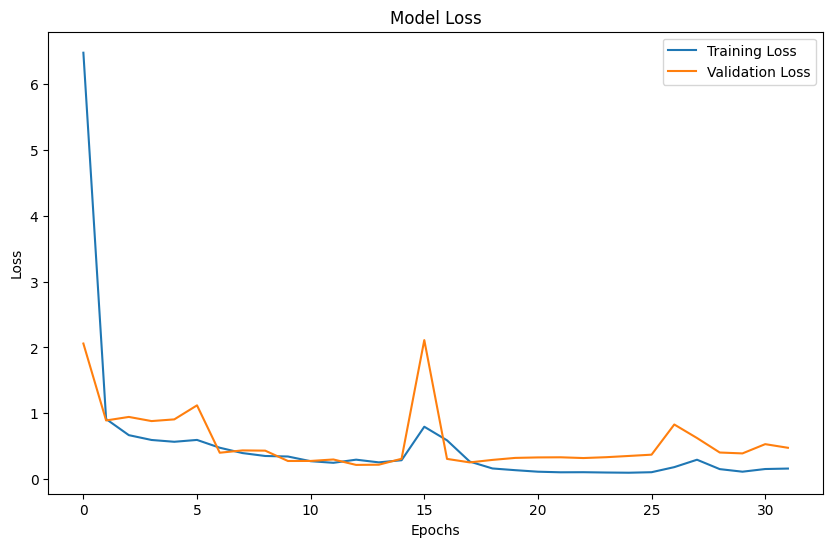

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

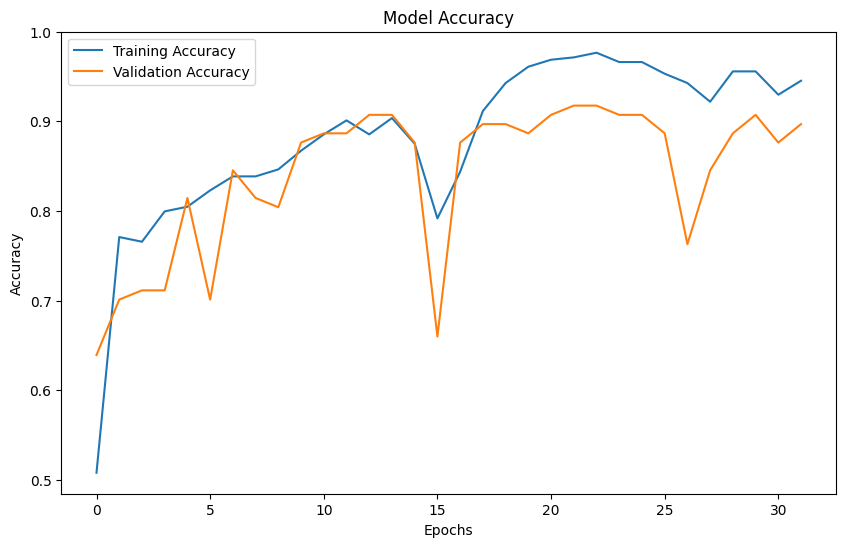

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

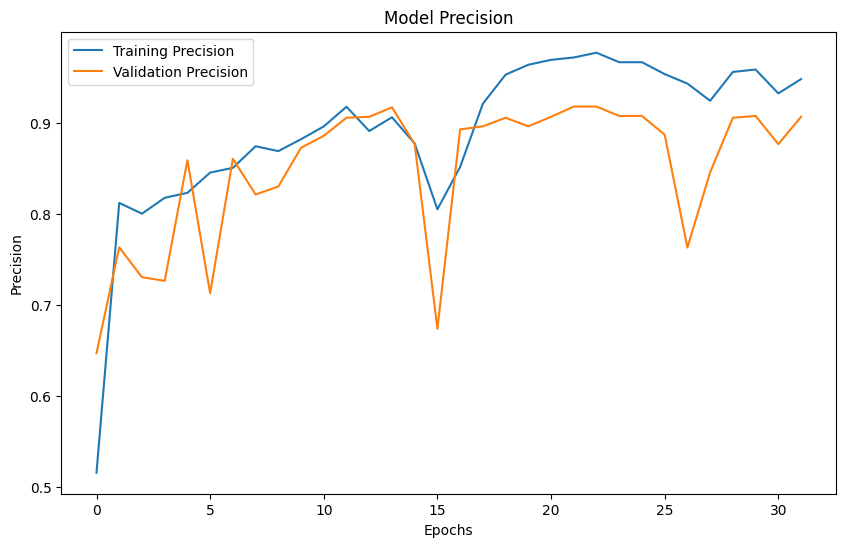

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['precision'], label='Training Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title('Model Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()

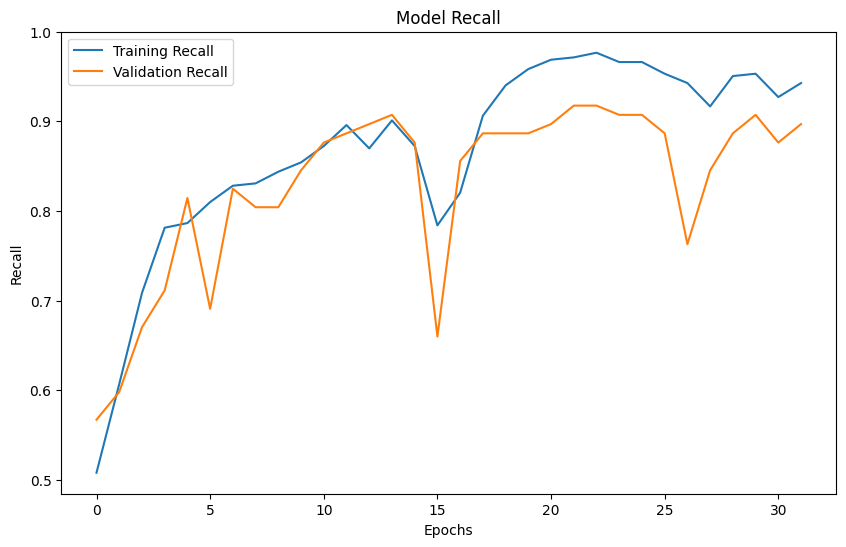

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Model Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

### Predictions

The metrics presented for each sample represent the output probabilities from a classification model that is predicting the likelihood of a given musical piece belonging to one of four composers: Bach, Beethoven, Mozart, or Chopin. These probabilities indicate how confident the model is that a particular sample belongs to each composer.

Based on the output probabilities, the model is predicting composers with extremely high confidence, we'll now plot a small sample of our predictions for an alternative view.

In [ ]:
predictions = model.predict([X_test,tempos_test])

predicted_classes = np.argmax(predictions, axis=1)

# Map predicted classes to composer names
class_to_composer = {0: 'Bach', 1: 'Beethoven', 2: 'Mozart', 3: 'Chopin'}
predicted_composers = [class_to_composer[pred] for pred in predicted_classes]

# Displays all class probabilities for each sample
for i, pred in enumerate(predictions):
    print(f"Sample {i + 1}:")
    for class_idx, class_prob in enumerate(pred):
        print(f"  {class_to_composer[class_idx]}: {class_prob:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Sample 1:
  Bach: 0.9946
  Beethoven: 0.0022
  Mozart: 0.0017
  Chopin: 0.0015
Sample 2:
  Bach: 0.0001
  Beethoven: 0.0000
  Mozart: 0.9835
  Chopin: 0.0164
Sample 3:
  Bach: 0.0001
  Beethoven: 0.0000
  Mozart: 0.9901
  Chopin: 0.0098
Sample 4:
  Bach: 0.0007
  Beethoven: 0.0000
  Mozart: 0.9993
  Chopin: 0.0000
Sample 5:
  Bach: 0.0007
  Beethoven: 0.0001
  Mozart: 0.9992
  Chopin: 0.0000
Sample 6:
  Bach: 0.0004
  Beethoven: 0.0000
  Mozart: 0.9995
  Chopin: 0.0000
Sample 7:
  Bach: 0.0000
  Beethoven: 0.0000
  Mozart: 0.9971
  Chopin: 0.0029
Sample 8:
  Bach: 0.0006
  Beethoven: 0.0000
  Mozart: 0.9993
  Chopin: 0.0000
Sample 9:
  Bach: 0.9943
  Beethoven: 0.0018
  Mozart: 0.0022
  Chopin: 0.0017
Sample 10:
  Bach: 0.0000
  Beethoven: 0.0073
  Mozart: 0.0019
  Chopin: 0.9908
Sample 11:
  Bach: 0.9948
  Beethoven: 0.0049
  Mozart: 0.0003
  Chopin: 0.0000
Sample 12:
  Bach: 0.0010
  Beethoven: 0.0001
  Mozart: 0.9988
  Chopin: 0.0000
Sample 13:


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


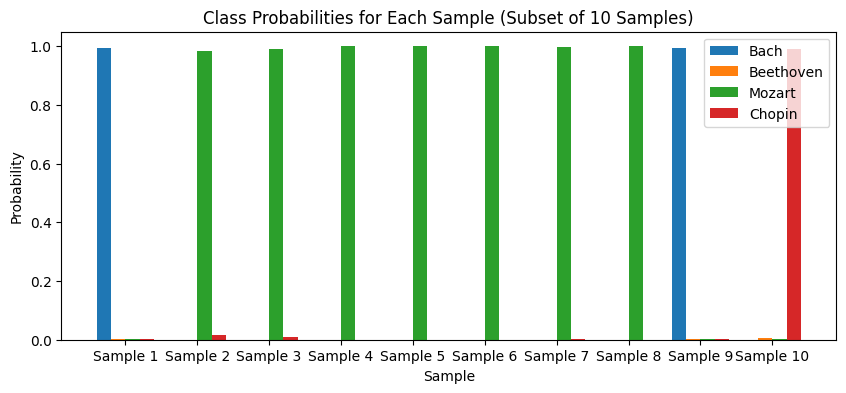

In [ ]:
# Sample predictions
predictions = model.predict([X_test, tempos_test])

# Map predicted classes to composer names
class_to_composer = {0: 'Bach', 1: 'Beethoven', 2: 'Mozart', 3: 'Chopin'}
composer_names = list(class_to_composer.values())

# Using a subset of the samples for better visualization
subset_size = 10  # Number of samples to visualize
predictions_subset = predictions[:subset_size]

# Create a grouped bar chart for the subset
num_samples_subset = len(predictions_subset)
num_classes = len(composer_names)
bar_width = 0.2
x_subset = np.arange(num_samples_subset)

fig, ax = plt.subplots(figsize=(10, 4))

# Plot the probabilities for each class in the subset
for i in range(num_classes):
    class_probabilities = predictions_subset[:, i]
    ax.bar(x_subset + i * bar_width, class_probabilities, bar_width, label=composer_names[i])

# Add labels and title
ax.set_xlabel('Sample')
ax.set_ylabel('Probability')
ax.set_title(f'Class Probabilities for Each Sample (Subset of {subset_size} Samples)')
ax.set_xticks(x_subset + bar_width * (num_classes - 1) / 2)
ax.set_xticklabels([f'Sample {i + 1}' for i in range(num_samples_subset)])
ax.legend()

plt.show()

### Learning Visualization

This section serves as another view of our model's architecture.

The model has two input layers: one for the sequence data and another for the tempo data. The sequence input layer receives data with a shape of (25, 4), meaning it expects sequences of 25 timesteps with 4 features at each timestep  corresponding to pitch, velocity, note start and note end.

The sequence data first passes through a 1D convolutional layer followed by a pooling layer, which reduces the spatial dimension by half, resulting in an output shape of (11, 32). The pooled output is then flattened into a 1D vector. Simultaneously, the tempo data is fed into a separate input layer. The flattened sequence data and the tempo input are concatenated, producing a combined input with 353 features.

To prepare the concatenated input for the LSTM layer, a Lambda layer is used to add an additional dimension, transforming the input shape to (1, 353) so that it can be processed by the LSTM layer. The LSTM layer, with 64 units, processes the combined features, capturing temporal dependencies and interactions between the sequence data and tempo.

Finally, an putput layer with 4 output units and a softmax activation function is applied to produce the final output, which consists of the probabilities corresponding to each of the four composers.


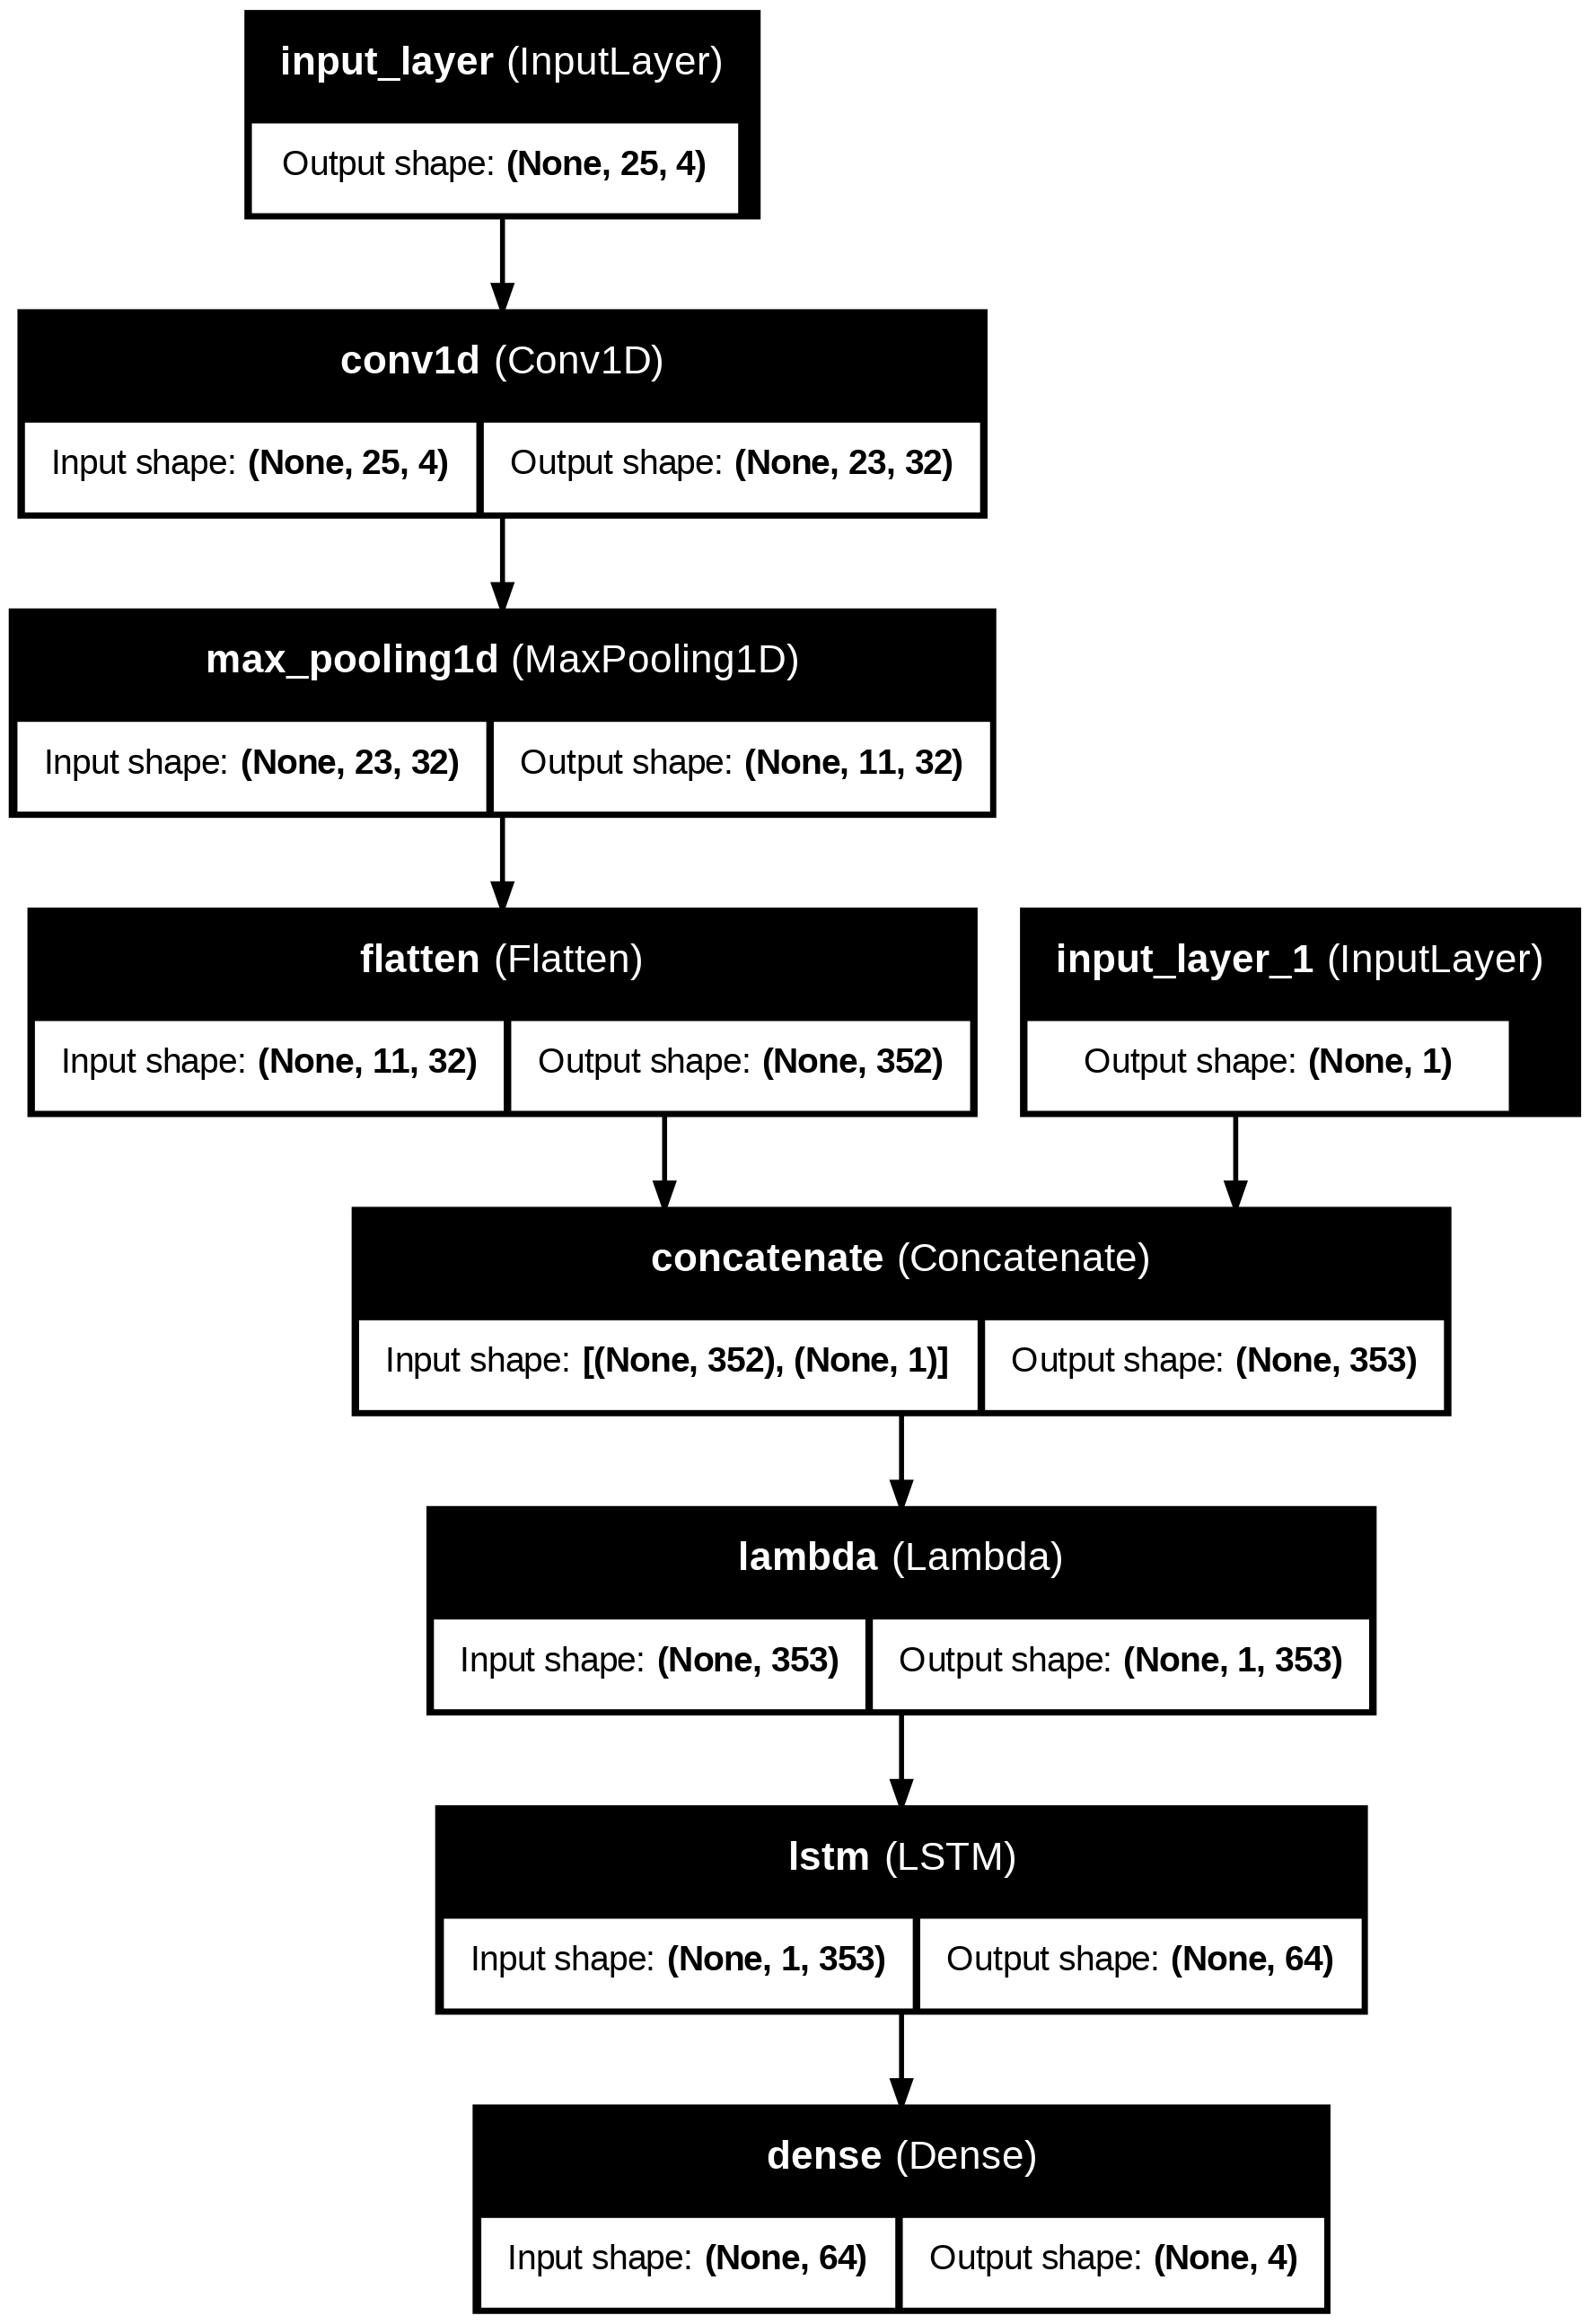

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True, show_layer_names=True)

## Model Optimization

Our model optimization/hyperparameter tuning section aims to improve the model's performance by recreating the model with options to pick the optimal set of hyperparameters. The Keras Tuner library allows us to conduct a random search for the best hyperparameters and use those hyperparameters to reconstruct the model and evaluate those metrics. When constructing our model architecture for hyperparameter search, we are optimizing the convolutional layer, LSTM layer and learning rate.

In [ ]:
# Defining Model Architecture for hyperparameter search
def build_model(hp):
  # Define the input layers
  sequence_input = Input(shape=(sequence_length, 4))
  tempo_input = Input(shape=(1,))

  # CNN Layer for pitch and velocity sequences
  x = Conv1D(filters=hp.Int('filters', min_value=16, max_value=64, step=16),
               kernel_size=hp.Choice('kernel_size', values=[3, 5]),
               activation='relu')(sequence_input)
  x = MaxPooling1D(2)(x)
  x = Flatten()(x)

  # Combine with tempo and time signature inputs
  x = concatenate([x, tempo_input])

  # LSTM Layer
  x = Lambda(lambda x: tf.expand_dims(x, axis=1))(x)
  x = LSTM(units=hp.Int('lstm_units', min_value=32, max_value=128, step=32),
             activation='relu')(x)
  output = Dense(4, activation='softmax')(x)

  # Define the model
  model = Model(inputs=[sequence_input, tempo_input], outputs=output)

  model.compile(optimizer=tf.keras.optimizers.Adam(
                      hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])), loss='categorical_crossentropy',
                 metrics=['accuracy',
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall'),
                tf.keras.metrics.F1Score(name='f1_score')])

  return model

In [ ]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=2,
    directory='/content/drive/MyDrive/AAI-511 Final Project Neural Networks and Deep Learning/Model Optimization',
    project_name='hyperparameter_tuning'
)

In [ ]:
tuner.search([X_train, tempos_train], y_train, validation_data=([X_test, tempos_test], y_test), epochs=10, batch_size=32,)

Trial 5 Complete [00h 00m 42s]
val_loss: 0.7149160504341125

Best val_loss So Far: 0.7149160504341125
Total elapsed time: 00h 03m 25s


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of filters in the Conv1D layer is {best_hps.get('filters')}.
The optimal kernel size for the Conv1D layer is {best_hps.get('kernel_size')}.
The optimal number of units in the LSTM layer is {best_hps.get('lstm_units')}.
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")


The optimal number of filters in the Conv1D layer is 48.
The optimal kernel size for the Conv1D layer is 3.
The optimal number of units in the LSTM layer is 128.
The optimal learning rate for the optimizer is 0.001.



### Modeling with Optimized Parameters

Modeling with optimized parameters yielded "better" results to the untrained eye, but the metrics show severe overfitting during the training phase. The model learned the training data exceptionally well, but struggles to maintain that same performance with the validation data. There is a significant drop off between training and validation metrics, the loss is near 0 and the accuracy is almost perfect. The overfitting could have happened because there's a need for regularlization techniques and a simpler model.

In [ ]:
opt_model = tuner.hypermodel.build(best_hps)

opt_history = opt_model.fit([X_train, tempos_train], y_train, validation_data=([X_test, tempos_test], y_test), epochs=100, batch_size=32)

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 523ms/step - accuracy: 0.5286 - f1_score: 0.3735 - loss: 4.8945 - precision: 0.5301 - recall: 0.5286 - val_accuracy: 0.5909 - val_f1_score: 0.4168 - val_loss: 1.5237 - val_precision: 0.5938 - val_recall: 0.5758
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - accuracy: 0.7246 - f1_score: 0.6187 - loss: 1.2124 - precision: 0.7229 - recall: 0.7003 - val_accuracy: 0.7576 - val_f1_score: 0.7237 - val_loss: 0.9590 - val_precision: 0.7656 - val_recall: 0.7424
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - accuracy: 0.7252 - f1_score: 0.6355 - loss: 0.7011 - precision: 0.7477 - recall: 0.7240 - val_accuracy: 0.6970 - val_f1_score: 0.7238 - val_loss: 0.8131 - val_precision: 0.7031 - val_recall: 0.6818
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 0.7494 - f1_score: 0.6808 - loss: 0.6392 - precision: 0.7618 - recall: 0.7433 - val_accuracy: 0.7576 - val_f1_score: 0.6802 - val_loss: 0.6285 - val_precision: 0.7812 - val_recall: 0.7

### Optimized Model Evaluation

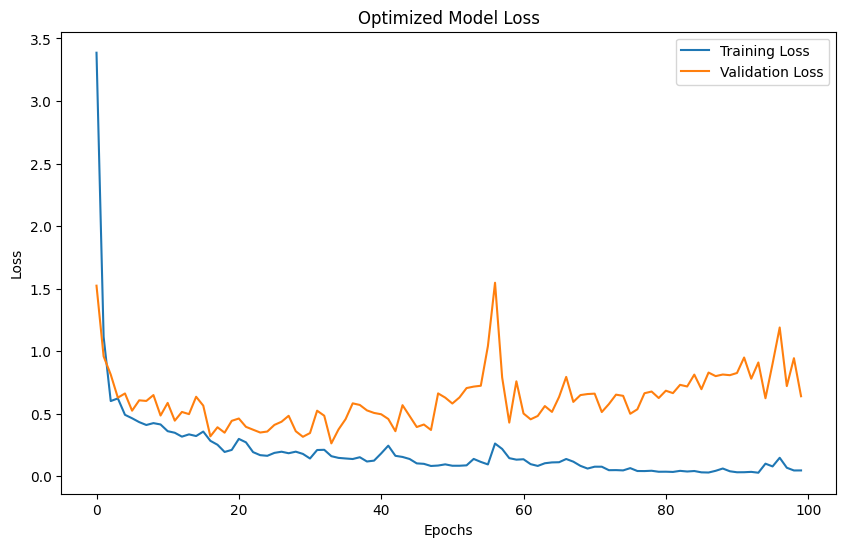

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(opt_history.history['loss'], label = 'Training Loss')
plt.plot(opt_history.history['val_loss'], label = 'Validation Loss')
plt.title('Optimized Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

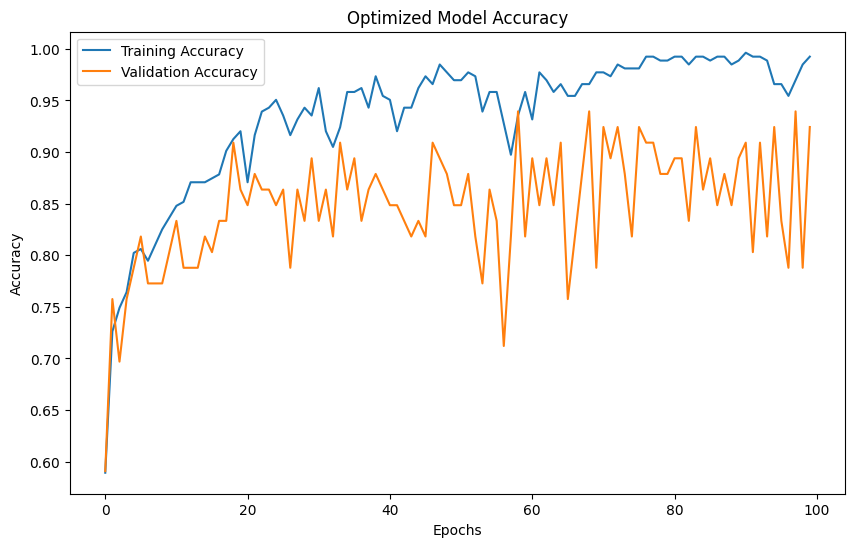

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(opt_history.history['accuracy'], label='Training Accuracy')
plt.plot(opt_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Optimized Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

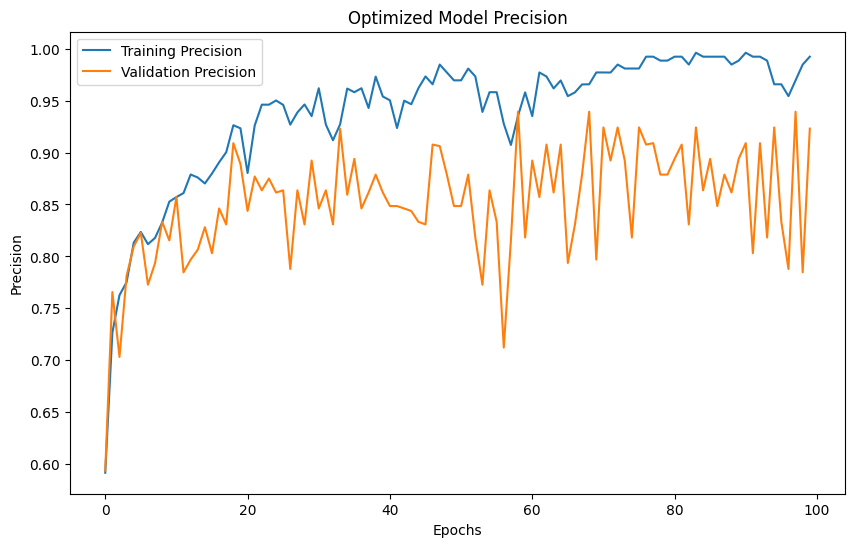

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(opt_history.history['precision'], label='Training Precision')
plt.plot(opt_history.history['val_precision'], label='Validation Precision')
plt.title('Optimized Model Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()

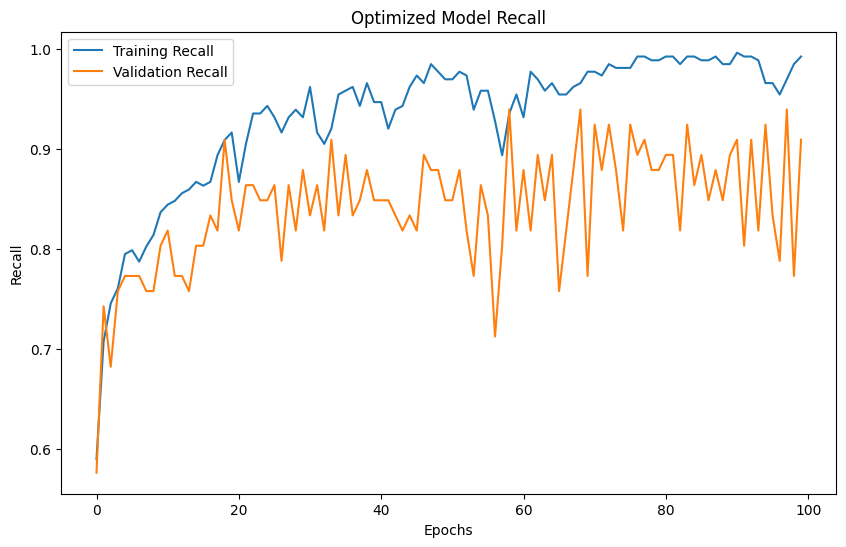

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(opt_history.history['recall'], label='Training Recall')
plt.plot(opt_history.history['val_recall'], label='Validation Recall')
plt.title('Optimized Model Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

##Conclusion

In conclusion, this project successfully demonstrated the potential of using a hybrid CNN and LSTM architecture, for classifying musical compositions by their composer based on the features extracted from MIDI files. The model's strong performance on the training set reflects its ability to capture complex patterns in musical features such as starts, ends, pitches, velocities, and tempo changes. However, the observed gap between the training and validation metrics highlights the challenge of overfitting, emphasizing the need for further refinement to ensure robust generalization. Future work could focus on enhancing the model's generalizability through techniques like regularization, data augmentation, and cross-validation. Overall, the insights gained from this project not only contribute to the field of music classification but also offer valuable lessons in the application of deep learning to time-series data, providing a solid foundation for future explorations in this area.


##References

Chollet, F., & others. (2015). Keras. GitHub. Retrieved from https://github.com/fchollet/keras

Colin Raffel and Daniel P. W. Ellis. Intuitive Analysis, Creation and Manipulation of MIDI Data with pretty_midi. In 15th International Conference on Music Information Retrieval Late Breaking and Demo Papers, 2014.

Glob - unix style pathname pattern expansion. Python documentation. (n.d.). https://docs.python.org/3/library/glob.html